# Install Required Libraries

In this cell, we install the `imageio` library, which is used for reading and writing image data. This will be useful later for creating and saving visualizations.


In [1]:
!pip install imageio

# Importing Libraries

We import all necessary libraries, including PyTorch for building and training our neural networks, and other utilities for data handling, visualization, and saving results.


In [2]:
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# Conditional Generative Adversarial Networks (cGANs)

Conditional Generative Adversarial Networks (cGANs) enhance the basic GAN architecture by incorporating label information to guide the image generation process. This allows cGANs to generate images that are conditioned on specific labels, making the generation process controllable and diverse.

## Architecture

The cGAN architecture involves two key components:
- **Generator (G)**: Takes a random noise vector and a label as input and generates images that correspond to the label.
- **Discriminator (D)**: Takes images and corresponding labels as input and distinguishes between real (from dataset) and fake (from generator) images.

In contrast to traditional GANs where the generation is unsupervised and unconditioned, cGANs utilize labels to produce targeted outputs. This conditioning happens as both the generator and discriminator receive the label information during training.

Label tensors are created, turned into one-hot encodings, and then concatenated with noise vectors before being fed into the generator. This allows the generator to produce output that is conditioned on the label information.

The discriminator also receives one-hot encoded labels concatenated with image data (either real or fake) to make decisions based on both the image and the corresponding label.


## Usage and Suitability for MNIST

cGANs are particularly useful for datasets like MNIST where each image corresponds to a labeled digit (0-9). By conditioning the generation process on these labels, cGANs can be directed to generate images of specific digits, enhancing the utility and applicability of the generated data for supervised learning tasks.

## Advantages Over Standard GANs

- **Controlled Generation**: Ability to specify the type of image to generate (e.g., a specific digit).
- **Improved Stability**: Conditioning stabilizes training by reducing mode collapse, a common issue in standard GANs where the generator produces limited varieties of outputs.
- **Higher Quality**: Images generated are often of higher quality and more relevant to practical applications since they are conditioned and less random.


# Simple Example Explaining cGAN Utility for MNIST
## Unconditional GAN:
- **Generation Process**: An unconditional GAN, when trained on the MNIST dataset, would learn to generate images that look like handwritten digits. However, you cannot control which digit is generated at any given time. The output might be a 0, 1, 2, etc., at random.

- **Use Case Limitation**: If you are developing an application that requires a large number of images of the digit '2' (perhaps for a specialized training dataset or data augmentation), an unconditional GAN would not be suitable. It would generate all digits indiscriminately, and obtaining enough images of the digit '2' would require generating many images and filtering out the undesired ones.

## Conditional GAN (cGAN):
-**Generation Process**: A cGAN trained on the MNIST dataset would not only learn to generate images that look like handwritten digits but also generate a specific digit based on a provided label. For example, if you provide the label '2' to the cGAN, it will generate images of the digit '2'.

-**Use Case Enablemen**: If your application needs many samples of the digit '2', a cGAN allows you to generate as many as needed directly, without the inefficiency of generating and discarding unwanted digits. This controlled generation is particularly useful for Data Augmentation(Creating more images of specific digits to balance a dataset or improve the robustness of classifiers.), Enhanced Training for Specific Tasks (Training classifiers on specific, hard-to-distinguish digits by generating more variants of them.)

# Weight Initialization Function

We define a function to initialize weights of the neural network layers using a normal distribution. Proper weight initialization can help in faster convergence during training.


In [6]:
def normal_init(m, mean, std):
    if isinstance(m, nn.Linear):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

# Generator Model

Here, we define the generator class for our cGAN. The generator takes random noise and class labels as input and outputs generated images. We also include a method for initializing weights.


In [4]:
class generator(nn.Module):
    # initializers
    def __init__(self):
        super(generator, self).__init__()
        self.fc1_1 = nn.Linear(100, 256)
        self.fc1_1_bn = nn.BatchNorm1d(256)
        self.fc1_2 = nn.Linear(10, 256)
        self.fc1_2_bn = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(512, 512)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc3_bn = nn.BatchNorm1d(1024)
        self.fc4 = nn.Linear(1024, 784)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, input, label):
        x = F.relu(self.fc1_1_bn(self.fc1_1(input)))
        y = F.relu(self.fc1_2_bn(self.fc1_2(label)))
        x = torch.cat([x, y], 1)
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = F.relu(self.fc3_bn(self.fc3(x)))
        x = F.tanh(self.fc4(x))

        return x        

# Discriminator Model

This cell defines the discriminator class for our cGAN. The discriminator evaluates the authenticity of images, determining whether they are real or generated. Like the generator, it also includes a weight initialization method.


In [5]:
class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()
        self.fc1_1 = nn.Linear(784, 1024)
        self.fc1_2 = nn.Linear(10, 1024)
        self.fc2 = nn.Linear(2048, 512)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.fc3_bn = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = F.leaky_relu(self.fc1_1(input), 0.2)
        y = F.leaky_relu(self.fc1_2(label), 0.2)
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.fc2_bn(self.fc2(x)), 0.2)
        x = F.leaky_relu(self.fc3_bn(self.fc3(x)), 0.2)
        x = F.sigmoid(self.fc4(x))

        return x

# Preparing Fixed Inputs for Evaluation

In this cell, we prepare fixed random noise vectors and class labels for evaluating the generator's performance throughout the training process.


In [8]:
temp_z_ = torch.rand(10, 100)
fixed_z_ = temp_z_
fixed_y_ = torch.zeros(10, 1)
for i in range(9):
    fixed_z_ = torch.cat([fixed_z_, temp_z_], 0)
    temp = torch.ones(10,1) + i
    fixed_y_ = torch.cat([fixed_y_, temp], 0)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


fixed_z_ = Variable(fixed_z_, volatile=True)
fixed_y_label_ = torch.zeros(100, 10)
fixed_y_label_.scatter_(1, fixed_y_.type(torch.LongTensor), 1)
fixed_y_label_ = Variable(fixed_y_label_, volatile=True)

/var/folders/tt/2b3cc4b54b349j97hzm_dr740000gn/T/ipykernel_99361/3680155935.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  fixed_z_ = Variable(fixed_z_, volatile=True)
/var/folders/tt/2b3cc4b54b349j97hzm_dr740000gn/T/ipykernel_99361/3680155935.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  fixed_y_label_ = Variable(fixed_y_label_, volatile=True)


# Visualizing Results

This function generates images using the generator and displays them in a grid. It saves the resulting image with the current epoch number in the filename.


In [9]:
def show_result(num_epoch, show = False, save = False, path = 'result.png'):

    G.eval()
    test_images = G(fixed_z_, fixed_y_label_)
    G.train()

    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(10*10):
        i = k // 10
        j = k % 10
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k].cpu().data.view(28, 28).numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

# Visualizing Training Loss

This function plots the discriminator and generator losses over epochs, providing insight into the training process. It saves the plot as an image file.


In [10]:
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

# Training the cGAN

This cell defines the training parameters and data loader for the MNIST dataset. It initializes the generator and discriminator networks, sets the loss function, and optimizers. Finally, it starts the training loop, updating the networks and tracking the losses.


In [18]:
# training parameters
batch_size = 128
lr = 0.0002
train_epoch = 50

# data_loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

# network
G = generator()
D = discriminator()
G.weight_init(mean=0, std=0.02)
D.weight_init(mean=0, std=0.02)

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []


# Training Loop with Temporary Directory

We wrap the training loop inside a context manager that creates a temporary directory for saving results. This ensures all generated files are stored temporarily and cleaned up after training.


training start!
[1/50] - ptime: 78.33, loss_d: 1.136, loss_g: 0.964
[2/50] - ptime: 82.90, loss_d: 1.011, loss_g: 1.198
[3/50] - ptime: 70.19, loss_d: 0.961, loss_g: 1.321
[4/50] - ptime: 95.44, loss_d: 0.899, loss_g: 1.479
[5/50] - ptime: 91.89, loss_d: 0.886, loss_g: 1.493
[6/50] - ptime: 89.59, loss_d: 0.804, loss_g: 1.641
[7/50] - ptime: 81.06, loss_d: 0.801, loss_g: 1.734
[8/50] - ptime: 66.39, loss_d: 0.894, loss_g: 1.540
[9/50] - ptime: 69.04, loss_d: 0.905, loss_g: 1.510
[10/50] - ptime: 72.58, loss_d: 0.933, loss_g: 1.456
[11/50] - ptime: 85.31, loss_d: 0.877, loss_g: 1.583
[12/50] - ptime: 85.72, loss_d: 0.914, loss_g: 1.496
[13/50] - ptime: 76.71, loss_d: 0.890, loss_g: 1.533
[14/50] - ptime: 62.16, loss_d: 0.905, loss_g: 1.512
[15/50] - ptime: 35.98, loss_d: 0.965, loss_g: 1.419
[16/50] - ptime: 35.38, loss_d: 0.915, loss_g: 1.497
[17/50] - ptime: 36.16, loss_d: 1.013, loss_g: 1.325
[18/50] - ptime: 40.56, loss_d: 1.021, loss_g: 1.296
[19/50] - ptime: 34.57, loss_d: 0.786, 

/var/folders/tt/2b3cc4b54b349j97hzm_dr740000gn/T/ipykernel_99361/920826128.py:153: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img_name))


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

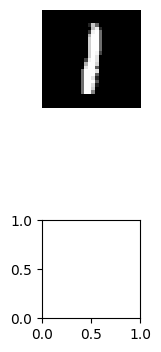

In [22]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms
from torch.autograd import Variable
import pickle
import imageio
import matplotlib.pyplot as plt
import tempfile

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define your generator and discriminator here

batch_size = 128
lr = 0.0002
train_epoch = 50

# data_loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

# network
G = generator().to(device)
D = discriminator().to(device)
G.weight_init(mean=0, std=0.02)
D.weight_init(mean=0, std=0.02)

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

# Create a temporary directory
with tempfile.TemporaryDirectory() as tempdir:
    fixed_results_dir = os.path.join(tempdir, 'Fixed_results')
    os.makedirs(fixed_results_dir)

    print('training start!')
    start_time = time.time()
    for epoch in range(train_epoch):
        D_losses = []
        G_losses = []

        # learning rate decay
        if (epoch + 1) == 30:
            G_optimizer.param_groups[0]['lr'] /= 10
            D_optimizer.param_groups[0]['lr'] /= 10
            print("learning rate change!")

        if (epoch + 1) == 40:
            G_optimizer.param_groups[0]['lr'] /= 10
            D_optimizer.param_groups[0]['lr'] /= 10
            print("learning rate change!")

        epoch_start_time = time.time()
        for x_, y_ in train_loader:
            # train discriminator D
            D.zero_grad()

            mini_batch = x_.size()[0]

            y_real_ = torch.ones(mini_batch, device=device)
            y_fake_ = torch.zeros(mini_batch, device=device)
            y_label_ = torch.zeros(mini_batch, 10, device=device)
            y_label_.scatter_(1, y_.view(mini_batch, 1).to(device), 1)

            x_ = x_.view(-1, 28 * 28).to(device)
            D_result = D(x_, y_label_).squeeze()
            D_real_loss = BCE_loss(D_result, y_real_)

            z_ = torch.rand((mini_batch, 100), device=device)
            y_ = (torch.rand(mini_batch, 1) * 10).type(torch.LongTensor).to(device)
            y_label_ = torch.zeros(mini_batch, 10, device=device)
            y_label_.scatter_(1, y_.view(mini_batch, 1), 1)

            G_result = G(z_, y_label_)

            D_result = D(G_result, y_label_).squeeze()
            D_fake_loss = BCE_loss(D_result, y_fake_)
            D_fake_score = D_result.data.mean()

            D_train_loss = D_real_loss + D_fake_loss

            D_train_loss.backward()
            D_optimizer.step()

            D_losses.append(D_train_loss.item())

            # train generator G
            G.zero_grad()

            z_ = torch.rand((mini_batch, 100), device=device)
            y_ = (torch.rand(mini_batch, 1) * 10).type(torch.LongTensor).to(device)
            y_label_ = torch.zeros(mini_batch, 10, device=device)
            y_label_.scatter_(1, y_.view(mini_batch, 1), 1)

            G_result = G(z_, y_label_)
            D_result = D(G_result, y_label_).squeeze()
            G_train_loss = BCE_loss(D_result, y_real_)
            G_train_loss.backward()
            G_optimizer.step()

            G_losses.append(G_train_loss.item())

        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                                      torch.mean(torch.FloatTensor(G_losses))))
        fixed_p = os.path.join(fixed_results_dir, f'MNIST_cGAN_{epoch + 1}.png')
        show_result((epoch + 1), save=True, path=fixed_p)
        train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
        train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
        train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

    end_time = time.time()
    total_ptime = end_time - start_time
    train_hist['total_ptime'].append(total_ptime)

    print("Avg one epoch ptime: %.2f, total %d epochs ptime: %.2f" % (torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])), train_epoch, total_ptime))
    print("Training finish!... save training results")

    # Save models and training history in the temporary directory
    torch.save(G.state_dict(), os.path.join(tempdir, "generator_param.pkl"))
    torch.save(D.state_dict(), os.path.join(tempdir, "discriminator_param.pkl"))
    with open(os.path.join(tempdir, 'train_hist.pkl'), 'wb') as f:
        pickle.dump(train_hist, f)

    show_train_hist(train_hist, save=True, path=os.path.join(tempdir, 'MNIST_cGAN_train_hist.png'))

    # Generate GIF of fake images over epochs
    images = []
    for e in range(train_epoch):
        img_name = os.path.join(fixed_results_dir, f'MNIST_cGAN_{e + 1}.png')
        images.append(imageio.imread(img_name))
    imageio.mimsave(os.path.join(tempdir, 'generation_animation.gif'), images, fps=5)

# Visualize real images vs generated fake images
def show_real_fake_images(real_images, fake_images, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(real_images[i].cpu().view(28, 28), cmap='gray')
        plt.axis('off')
        
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(fake_images[i].cpu().view(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Get some real images and fake images for visualization
real_images, _ = next(iter(train_loader))
real_images = real_images[:10].to(device)

z_ = torch.rand((10, 100), device=device)
y_ = (torch.rand(10, 1) * 10).type(torch.LongTensor).to(device)
y_label_ = torch.zeros(10, 10, device=device)
y_label_.scatter_(1, y_.view(10, 1), 1)
fake_images = G(z_, y_label_)

show_real_fake_images(real_images, fake_images)


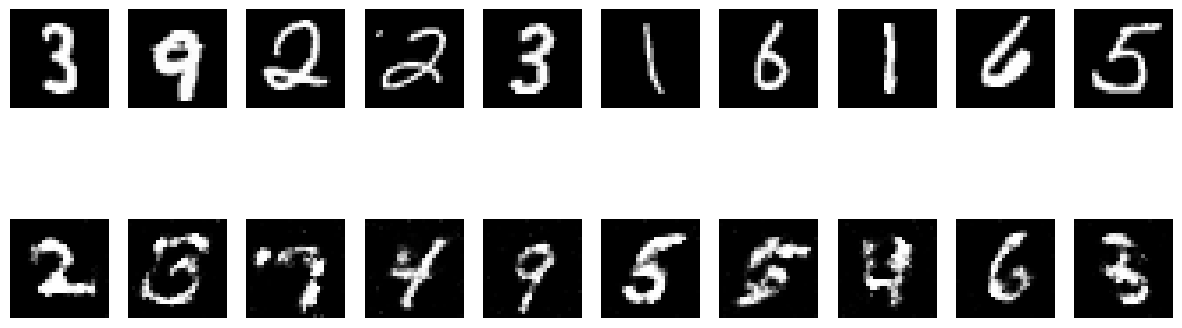

In [24]:
import matplotlib.pyplot as plt

# Visualize real images vs generated fake images
def show_real_fake_images(real_images, fake_images, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(real_images[i].cpu().detach().view(28, 28), cmap='gray')  # Detach and then view as numpy
        plt.axis('off')
        
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(fake_images[i].cpu().detach().view(28, 28), cmap='gray')  # Detach and then view as numpy
        plt.axis('off')
    plt.show()

# Assuming real_images and fake_images are already defined and populated

# Example usage:
show_real_fake_images(real_images, fake_images)


In [66]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms
from torch.autograd import Variable
import pickle
import imageio
import matplotlib.pyplot as plt
import tempfile

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define your generator and discriminator here

batch_size = 128
lr = 0.0001
train_epoch = 16

# data_loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

# network
G = generator().to(device)
D = discriminator().to(device)
G.weight_init(mean=0, std=0.02)
D.weight_init(mean=0, std=0.02)

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

# Create a temporary directory
with tempfile.TemporaryDirectory() as tempdir:
    fixed_results_dir = os.path.join(tempdir, 'Fixed_results')
    os.makedirs(fixed_results_dir)

    print('training start!')
    start_time = time.time()
    for epoch in range(train_epoch):
        D_losses = []
        G_losses = []

        

        epoch_start_time = time.time()
        for x_, y_ in train_loader:
            # train discriminator D
            D.zero_grad()

            mini_batch = x_.size()[0]

            y_real_ = torch.ones(mini_batch, device=device)
            y_fake_ = torch.zeros(mini_batch, device=device)
            y_label_ = torch.zeros(mini_batch, 10, device=device)
            y_label_.scatter_(1, y_.view(mini_batch, 1).to(device), 1)

            x_ = x_.view(-1, 28 * 28).to(device)
            D_result = D(x_, y_label_).squeeze()
            D_real_loss = BCE_loss(D_result, y_real_)

            z_ = torch.rand((mini_batch, 100), device=device)
            y_ = (torch.rand(mini_batch, 1) * 10).type(torch.LongTensor).to(device)
            y_label_ = torch.zeros(mini_batch, 10, device=device)
            y_label_.scatter_(1, y_.view(mini_batch, 1), 1)

            G_result = G(z_, y_label_)

            D_result = D(G_result, y_label_).squeeze()
            D_fake_loss = BCE_loss(D_result, y_fake_)
            D_fake_score = D_result.data.mean()

            D_train_loss = D_real_loss + D_fake_loss

            D_train_loss.backward()
            D_optimizer.step()

            D_losses.append(D_train_loss.item())

            # train generator G
            G.zero_grad()

            z_ = torch.rand((mini_batch, 100), device=device)
            y_ = (torch.rand(mini_batch, 1) * 10).type(torch.LongTensor).to(device)
            y_label_ = torch.zeros(mini_batch, 10, device=device)
            y_label_.scatter_(1, y_.view(mini_batch, 1), 1)

            G_result = G(z_, y_label_)
            D_result = D(G_result, y_label_).squeeze()
            G_train_loss = BCE_loss(D_result, y_real_)
            G_train_loss.backward()
            G_optimizer.step()

            G_losses.append(G_train_loss.item())

        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                                      torch.mean(torch.FloatTensor(G_losses))))
        fixed_p = os.path.join(fixed_results_dir, f'MNIST_cGAN_{epoch + 1}.png')
        show_result((epoch + 1), save=True, path=fixed_p)
        train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
        train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
        train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

    end_time = time.time()
    total_ptime = end_time - start_time
    train_hist['total_ptime'].append(total_ptime)

    print("Avg one epoch ptime: %.2f, total %d epochs ptime: %.2f" % (torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])), train_epoch, total_ptime))
    print("Training finish!... save training results")

    # Save models and training history in the temporary directory
    torch.save(G.state_dict(), os.path.join(tempdir, "generator_param.pkl"))
    torch.save(D.state_dict(), os.path.join(tempdir, "discriminator_param.pkl"))
    with open(os.path.join(tempdir, 'train_hist.pkl'), 'wb') as f:
        pickle.dump(train_hist, f)

    show_train_hist(train_hist, save=True, path=os.path.join(tempdir, 'MNIST_cGAN_train_hist.png'))

    



# Get some real images and fake images for visualization
real_images, _ = next(iter(train_loader))
real_images = real_images[:10].to(device)

z_ = torch.rand((10, 100), device=device)
y_ = (torch.rand(10, 1) * 10).type(torch.LongTensor).to(device)
y_label_ = torch.zeros(10, 10, device=device)
y_label_.scatter_(1, y_.view(10, 1), 1)
fake_images = G(z_, y_label_)




training start!
[1/100] - ptime: 67.57, loss_d: 1.142, loss_g: 0.902
[2/100] - ptime: 56.83, loss_d: 0.957, loss_g: 1.141
[3/100] - ptime: 54.57, loss_d: 0.846, loss_g: 1.334
[4/100] - ptime: 54.95, loss_d: 0.802, loss_g: 1.459
[5/100] - ptime: 54.53, loss_d: 0.810, loss_g: 1.478
[6/100] - ptime: 57.02, loss_d: 0.787, loss_g: 1.546
[7/100] - ptime: 54.48, loss_d: 0.759, loss_g: 1.597
[8/100] - ptime: 58.56, loss_d: 0.783, loss_g: 1.586
[9/100] - ptime: 58.01, loss_d: 0.751, loss_g: 1.638
[10/100] - ptime: 54.89, loss_d: 0.762, loss_g: 1.625
[11/100] - ptime: 54.93, loss_d: 0.762, loss_g: 1.623
[12/100] - ptime: 54.47, loss_d: 0.776, loss_g: 1.650
[13/100] - ptime: 55.29, loss_d: 0.793, loss_g: 1.616
[14/100] - ptime: 54.75, loss_d: 0.785, loss_g: 1.639
[15/100] - ptime: 53.42, loss_d: 0.809, loss_g: 1.621
[16/100] - ptime: 54.83, loss_d: 0.814, loss_g: 1.571
[17/100] - ptime: 53.88, loss_d: 0.801, loss_g: 1.610
[18/100] - ptime: 54.09, loss_d: 0.794, loss_g: 1.640
[19/100] - ptime: 52.

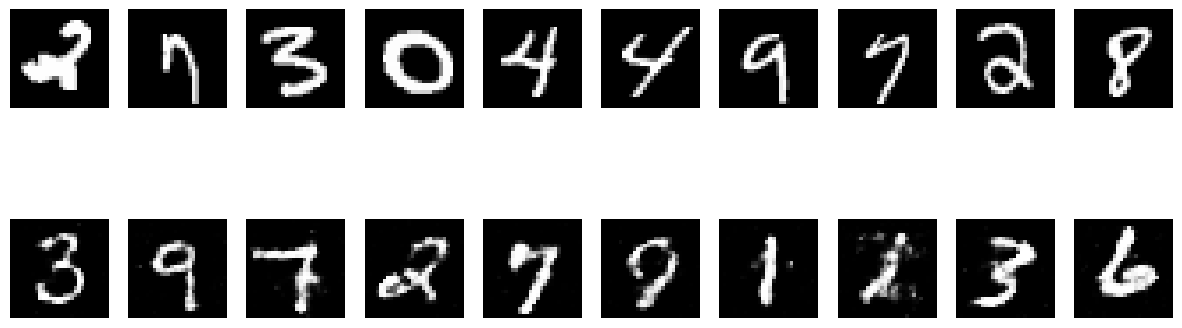

In [67]:
import matplotlib.pyplot as plt

# Visualize real images vs generated fake images
def show_real_fake_images(real_images, fake_images, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(real_images[i].cpu().detach().view(28, 28), cmap='gray')  # Detach and then view as numpy
        plt.axis('off')
        
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(fake_images[i].cpu().detach().view(28, 28), cmap='gray')  # Detach and then view as numpy
        plt.axis('off')
    plt.show()

# Assuming real_images and fake_images are already defined and populated

# Example usage:
show_real_fake_images(real_images, fake_images)


In [74]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms
from torch.autograd import Variable
import pickle
import imageio
import matplotlib.pyplot as plt
import tempfile

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define your generator and discriminator here

batch_size = 128
lr = 0.0002
train_epoch = 100

# data_loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

# network
G = generator().to(device)
D = discriminator().to(device)
G.weight_init(mean=0, std=0.02)
D.weight_init(mean=0, std=0.02)

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

# Create a temporary directory
with tempfile.TemporaryDirectory() as tempdir:
    fixed_results_dir = os.path.join(tempdir, 'Fixed_results')
    os.makedirs(fixed_results_dir)

    print('training start!')
    start_time = time.time()
    for epoch in range(train_epoch):
        D_losses = []
        G_losses = []

        # learning rate decay
        if (epoch + 1) == 30:
            G_optimizer.param_groups[0]['lr'] /= 10
            D_optimizer.param_groups[0]['lr'] /= 10
            print("learning rate change!")

        if (epoch + 1) == 60:
            G_optimizer.param_groups[0]['lr'] /= 10
            D_optimizer.param_groups[0]['lr'] /= 10
            print("learning rate change!")

        epoch_start_time = time.time()
        for x_, y_ in train_loader:
            # train discriminator D
            D.zero_grad()

            mini_batch = x_.size()[0]

            y_real_ = torch.ones(mini_batch, device=device)
            y_fake_ = torch.zeros(mini_batch, device=device)
            y_label_ = torch.zeros(mini_batch, 10, device=device)
            y_label_.scatter_(1, y_.view(mini_batch, 1).to(device), 1)

            x_ = x_.view(-1, 28 * 28).to(device)
            D_result = D(x_, y_label_).squeeze()
            D_real_loss = BCE_loss(D_result, y_real_)

            z_ = torch.rand((mini_batch, 100), device=device)
            y_ = (torch.rand(mini_batch, 1) * 10).type(torch.LongTensor).to(device)
            y_label_ = torch.zeros(mini_batch, 10, device=device)
            y_label_.scatter_(1, y_.view(mini_batch, 1), 1)

            G_result = G(z_, y_label_)

            D_result = D(G_result, y_label_).squeeze()
            D_fake_loss = BCE_loss(D_result, y_fake_)
            D_fake_score = D_result.data.mean()

            D_train_loss = D_real_loss + D_fake_loss

            D_train_loss.backward()
            D_optimizer.step()

            D_losses.append(D_train_loss.item())

            # train generator G
            G.zero_grad()

            z_ = torch.rand((mini_batch, 100), device=device)
            y_ = (torch.rand(mini_batch, 1) * 10).type(torch.LongTensor).to(device)
            y_label_ = torch.zeros(mini_batch, 10, device=device)
            y_label_.scatter_(1, y_.view(mini_batch, 1), 1)

            G_result = G(z_, y_label_)
            D_result = D(G_result, y_label_).squeeze()
            G_train_loss = BCE_loss(D_result, y_real_)
            G_train_loss.backward()
            G_optimizer.step()

            G_losses.append(G_train_loss.item())

        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                                      torch.mean(torch.FloatTensor(G_losses))))
        fixed_p = os.path.join(fixed_results_dir, f'MNIST_cGAN_{epoch + 1}.png')
        show_result((epoch + 1), save=True, path=fixed_p)
        train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
        train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
        train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

    end_time = time.time()
    total_ptime = end_time - start_time
    train_hist['total_ptime'].append(total_ptime)

    print("Avg one epoch ptime: %.2f, total %d epochs ptime: %.2f" % (torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])), train_epoch, total_ptime))
    print("Training finish!... save training results")

    # Save models and training history in the temporary directory
    torch.save(G.state_dict(), os.path.join(tempdir, "generator_param.pkl"))
    torch.save(D.state_dict(), os.path.join(tempdir, "discriminator_param.pkl"))
    with open(os.path.join(tempdir, 'train_hist.pkl'), 'wb') as f:
        pickle.dump(train_hist, f)

    show_train_hist(train_hist, save=True, path=os.path.join(tempdir, 'MNIST_cGAN_train_hist.png'))

    



# Get some real images and fake images for visualization
real_images, _ = next(iter(train_loader))
real_images = real_images[:10].to(device)

z_ = torch.rand((10, 100), device=device)
y_ = (torch.rand(10, 1) * 10).type(torch.LongTensor).to(device)
y_label_ = torch.zeros(10, 10, device=device)
y_label_.scatter_(1, y_.view(10, 1), 1)
fake_images = G(z_, y_label_)




training start!
[1/100] - ptime: 45.28, loss_d: 1.138, loss_g: 0.961
[2/100] - ptime: 43.50, loss_d: 1.038, loss_g: 1.152
[3/100] - ptime: 29.70, loss_d: 0.970, loss_g: 1.287
[4/100] - ptime: 32.47, loss_d: 0.894, loss_g: 1.464
[5/100] - ptime: 40.73, loss_d: 0.878, loss_g: 1.533
[6/100] - ptime: 50.41, loss_d: 0.859, loss_g: 1.545
[7/100] - ptime: 41.95, loss_d: 0.861, loss_g: 1.571
[8/100] - ptime: 46.68, loss_d: 0.936, loss_g: 1.454
[9/100] - ptime: 42.72, loss_d: 0.957, loss_g: 1.392
[10/100] - ptime: 42.93, loss_d: 0.917, loss_g: 1.477
[11/100] - ptime: 42.28, loss_d: 0.985, loss_g: 1.352
[12/100] - ptime: 42.30, loss_d: 0.942, loss_g: 1.423
[13/100] - ptime: 44.28, loss_d: 0.697, loss_g: 1.900
[14/100] - ptime: 43.50, loss_d: 0.524, loss_g: 2.556
[15/100] - ptime: 43.42, loss_d: 0.950, loss_g: 1.476
[16/100] - ptime: 42.75, loss_d: 0.945, loss_g: 1.463
[17/100] - ptime: 42.92, loss_d: 1.001, loss_g: 1.315
[18/100] - ptime: 43.16, loss_d: 0.999, loss_g: 1.343
[19/100] - ptime: 44.

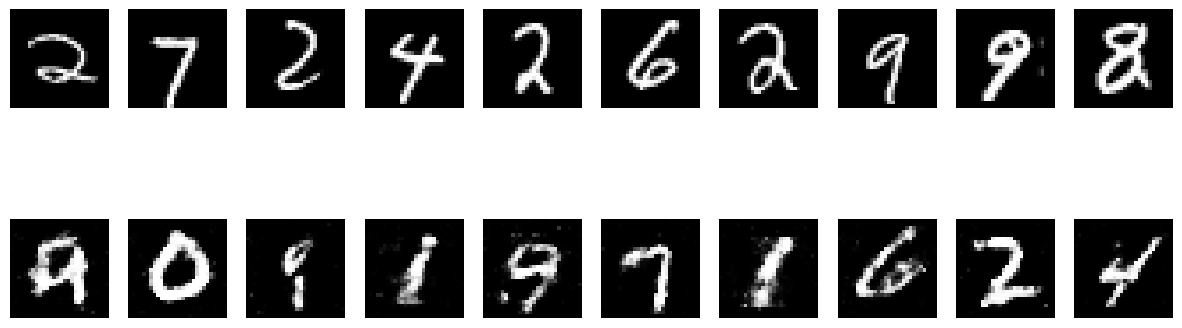

In [75]:
import matplotlib.pyplot as plt

# Visualize real images vs generated fake images
def show_real_fake_images(real_images, fake_images, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(real_images[i].cpu().detach().view(28, 28), cmap='gray')  # Detach and then view as numpy
        plt.axis('off')
        
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(fake_images[i].cpu().detach().view(28, 28), cmap='gray')  # Detach and then view as numpy
        plt.axis('off')
    plt.show()

# Assuming real_images and fake_images are already defined and populated

# Example usage:
show_real_fake_images(real_images, fake_images)


## Theory and Mathematics of Fréchet Inception Distance (FID)

Fréchet Inception Distance (FID) is a popular metric used to evaluate the quality of images generated by GANs by comparing the statistical distance between real and generated images.

### Mathematical Definition

FID calculates the distance between two multivariate Gaussians:

$$ FID = ||\mu_r - \mu_g||^2 + Tr(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1/2}) $$

Where:
- $\mu_r, \Sigma_r$ are the mean and covariance of the real data features.
- $\mu_g, \Sigma_g$ are the mean and covariance of the generated data features.
- $Tr$ denotes the trace of a matrix, capturing the sum of diagonal elements.

### Computation

1. Use a deep neural network, like InceptionV3, to extract feature vectors from both real and generated images.
2. Calculate the mean and covariance of these feature vectors for both real and generated datasets.
3. Compute the FID using the above formula, providing a quantitative measure of similarity between real and generated images. Lower FID values indicate better generative model performance.


# Helper Functions:
These functions help in computing features and statistics.



# Data Loaders for Real and Generated Images:

In [36]:
!pip install --upgrade pip



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0


In [41]:
# Install virtualenv if it's not installed
!pip install virtualenv

# Create a new virtual environment (replace `./venv` with your preferred path)
!virtualenv ./venv

# Activate the virtual environment
# On Windows
!.\venv\Scripts\activate
# On Unix or MacOS
!source ./venv/bin/activate

# Try installing the package again
!pip install fid_score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 6.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 7.5 MB/s eta 0:00:00ta 0:00:01
usage: virtualenv [--version] [--with-traceback] [-v | -q] [--read-only-app-data] [--app-data APP_DATA] [--reset-app-data] [--upgrade-embed-wheels] [--discovery {builtin}] [-p py] [--try-first-with py_exe]
                  [--creator {builtin,cpython3-posix,venv}] [--seeder {app-data,pip}] [--no-seed] [--activators comma_sep_list] [--clear] [--no-vcs-ignore] [--system-site-packages] [--symlinks | --copies] [--no-download | --download]
                  [--extra-search-dir d [d ...]] [--pip version] [--setuptools version] [--wheel version] [--no-pip] [--no-setuptools] [--no-wheel] [--no-periodic-update] [--symlink-app-data] [--prompt prompt] [-h]
                  dest
virtualenv: error: argument dest: the destination . is not write-able at /
SystemExit: 2
zsh:1: command not found: .venvScriptsactivate
zsh:sourc

In [42]:
!pip install pytorch-fid


In [62]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import inception_v3
import numpy as np
from scipy.linalg import sqrtm

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load real dataset with correct transformations
transform = transforms.Compose([
    transforms.Resize(299),  # Resize images for Inception V3
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize for grayscale images
])
real_dataset = datasets.MNIST(root='/tmp/data', train=True, download=True, transform=transform)
real_loader = DataLoader(real_dataset, batch_size=50, shuffle=True)

# Assuming G is your trained generator model
G = G.to(device).eval()

# Function to convert grayscale images to RGB
def to_rgb(x):
    # x should be of shape (N, 1, H, W)
    return x.repeat(1, 3, 1, 1)  # Repeat the channel dimension

def generate_fake_images(generator, num_samples, num_classes=10):
    z = torch.randn(num_samples, 100, device=device)  # Latent space vector
    # Generate random labels
    labels = torch.randint(0, num_classes, (num_samples,), device=device)
    # If your generator requires one-hot encoded labels, use the following line
    labels_onehot = torch.nn.functional.one_hot(labels, num_classes).float().to(device)

    # Generate images with the generator
    fake_images = generator(z, labels_onehot).detach()  # Ensure labels are in the expected format

    # Resize images to match the Inception V3 size and repeat grayscale images to 3 channels
    fake_images = fake_images.view(-1, 1, 28, 28)  # Correct shape for MNIST
    fake_images = fake_images.repeat(1, 3, 1, 1)  # Convert to 3 channels
    fake_images = torch.nn.functional.interpolate(fake_images, size=(299, 299))  # Resize to 299x299

    return fake_images

# Assuming G is your conditional GAN generator model
G = G.to(device).eval()

# Generate fake images and create DataLoader
fake_images = generate_fake_images(G, 1000)
fake_loader = DataLoader(TensorDataset(fake_images), batch_size=50, shuffle=False)


# Function to calculate FID
def calculate_fid(real_loader, fake_loader, device):
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.fc = torch.nn.Identity()  # Remove last fully connected layer
    model.eval()

    def get_activations(loader):
        activations = []
        with torch.no_grad():
            for batch in loader:
                images = batch[0].to(device)
                images = to_rgb(images)  # Convert grayscale images to RGB
                activations.append(model(images).cpu().numpy())
        return np.concatenate(activations, axis=0)

    act1 = get_activations(real_loader)
    act2 = get_activations(fake_loader)

    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# Calculate FID
fid_score = calculate_fid(real_loader, fake_loader, device)
print(f"FID score: {fid_score}")




FID score: 93.27
